In [ ]:
!pip install torch-lucent

  Preparing metadata (setup.py) ... done
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.7/234.7 kB 20.7 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=d0e663dfabcc1891c795343eb0f2c41c14b95bbb6f30a12f2f09517ac680af6e
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import os
import multiprocessing as mp
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast
import pickle

## Lucent
import lucent
from lucent.optvis import render

import matplotlib.pyplot as plt


In [ ]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip -d /content/

URL transformed to HTTPS due to an HSTS policy
--2024-05-22 18:46:22--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip.1’

tiny-imagenet-200.z 100%[===================>] 236.61M  7.33MB/s    in 42s     

2024-05-22 18:47:05 (5.69 MB/s) - ‘tiny-imagenet-200.zip.1’ saved [248100043/248100043]

replace /content/tiny-imagenet-200/words.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/tiny-imagenet-200/wnids.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
replace /content/tiny-imagenet-200/test/images/test_1860.JPEG? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
replace /content/tiny-imagenet-200/test/images/test_613.JPEG? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
replace /content/tiny-imagenet-200/test/i

In [ ]:
# Configures the device for PyTorch operations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


In [ ]:
# Define the path to the directory you want to remove
directory_to_remove = '/content/data.pkl'

# Use the !rm -rf command to remove the directory
!rm -rf {directory_to_remove}

# Verify that the directory has been removed
!ls /content/

drive  sample_data  tiny-imagenet-200  tiny-imagenet-200.zip


### **TRAINING**


In [ ]:

# Set the start method for multiprocessing
mp.set_start_method('spawn', force=True)

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the path to your dataset folder
data_dir = '/content/tiny-imagenet-200/'

# Load the training dataset
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'train'), transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8)

# Load pretrained ResNet-18 model
model = models.resnet18(pretrained=True)

# Modify the final layer to match the number of classes in Tiny ImageNet (200 classes)
num_classes = 200
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move the model to the device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize the GradScaler for mixed precision training
scaler = GradScaler()

# Training loop with progress bar
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)  # Move data to GPU
        optimizer.zero_grad()
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')

# Save the model weights
save_path = '/content/drive/My Drive/resnet18_ti.pth'
torch.save(model.state_dict(), save_path)
print(f'Model weights saved to {save_path}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cuda:0


Epoch 1/20: 100%|██████████| 782/782 [01:23<00:00,  9.33it/s]


Epoch 1/20, Loss: 2.539619523698412


Epoch 2/20: 100%|██████████| 782/782 [01:23<00:00,  9.39it/s]


Epoch 2/20, Loss: 1.6909859951804667


Epoch 3/20: 100%|██████████| 782/782 [01:23<00:00,  9.39it/s]


Epoch 3/20, Loss: 1.255802931992904


Epoch 4/20: 100%|██████████| 782/782 [01:23<00:00,  9.39it/s]


Epoch 4/20, Loss: 0.8936906165783972


Epoch 5/20: 100%|██████████| 782/782 [01:22<00:00,  9.43it/s]


Epoch 5/20, Loss: 0.6009426355895484


Epoch 6/20: 100%|██████████| 782/782 [01:22<00:00,  9.43it/s]


Epoch 6/20, Loss: 0.40668569381355935


Epoch 7/20: 100%|██████████| 782/782 [01:23<00:00,  9.41it/s]


Epoch 7/20, Loss: 0.3096416600601143


Epoch 8/20: 100%|██████████| 782/782 [01:23<00:00,  9.42it/s]


Epoch 8/20, Loss: 0.2560652814938894


Epoch 9/20: 100%|██████████| 782/782 [01:22<00:00,  9.48it/s]


Epoch 9/20, Loss: 0.2234427498134277


Epoch 10/20: 100%|██████████| 782/782 [01:22<00:00,  9.46it/s]


Epoch 10/20, Loss: 0.20369092600367716


Epoch 11/20: 100%|██████████| 782/782 [01:22<00:00,  9.52it/s]


Epoch 11/20, Loss: 0.18274135075871598


Epoch 12/20: 100%|██████████| 782/782 [01:23<00:00,  9.40it/s]


Epoch 12/20, Loss: 0.1666318933905848


Epoch 13/20: 100%|██████████| 782/782 [01:22<00:00,  9.43it/s]


Epoch 13/20, Loss: 0.1516391289160799


Epoch 14/20: 100%|██████████| 782/782 [01:23<00:00,  9.42it/s]


Epoch 14/20, Loss: 0.15461628270023467


Epoch 15/20: 100%|██████████| 782/782 [01:22<00:00,  9.48it/s]


Epoch 15/20, Loss: 0.13023390901058227


Epoch 16/20: 100%|██████████| 782/782 [01:22<00:00,  9.46it/s]


Epoch 16/20, Loss: 0.1417949058120246


Epoch 17/20: 100%|██████████| 782/782 [01:22<00:00,  9.53it/s]


Epoch 17/20, Loss: 0.12600704586928915


Epoch 18/20: 100%|██████████| 782/782 [01:22<00:00,  9.45it/s]


Epoch 18/20, Loss: 0.10727195414688315


Epoch 19/20: 100%|██████████| 782/782 [01:22<00:00,  9.48it/s]


Epoch 19/20, Loss: 0.10600707917581395


Epoch 20/20: 100%|██████████| 782/782 [01:22<00:00,  9.45it/s]

Epoch 20/20, Loss: 0.11626710893486238
Model weights saved to /content/drive/My Drive/resnet18_ti.pth


### Getting Layer names




In [ ]:
# Load a pretrained ResNet-18 model
model = models.resnet18(pretrained=True)

# Print all layer names using named_modules()
print("Layer names using named_modules():")
for name, module in model.named_modules():
    print(name)

# Print all top-level layer names using named_children()
print("\nTop-level layer names using named_children():")
for name, module in model.named_children():
    print(name)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 193MB/s]


Layer names using named_modules():

conv1
bn1
relu
maxpool
layer1
layer1.0
layer1.0.conv1
layer1.0.bn1
layer1.0.relu
layer1.0.conv2
layer1.0.bn2
layer1.1
layer1.1.conv1
layer1.1.bn1
layer1.1.relu
layer1.1.conv2
layer1.1.bn2
layer2
layer2.0
layer2.0.conv1
layer2.0.bn1
layer2.0.relu
layer2.0.conv2
layer2.0.bn2
layer2.0.downsample
layer2.0.downsample.0
layer2.0.downsample.1
layer2.1
layer2.1.conv1
layer2.1.bn1
layer2.1.relu
layer2.1.conv2
layer2.1.bn2
layer3
layer3.0
layer3.0.conv1
layer3.0.bn1
layer3.0.relu
layer3.0.conv2
layer3.0.bn2
layer3.0.downsample
layer3.0.downsample.0
layer3.0.downsample.1
layer3.1
layer3.1.conv1
layer3.1.bn1
layer3.1.relu
layer3.1.conv2
layer3.1.bn2
layer4
layer4.0
layer4.0.conv1
layer4.0.bn1
layer4.0.relu
layer4.0.conv2
layer4.0.bn2
layer4.0.downsample
layer4.0.downsample.0
layer4.0.downsample.1
layer4.1
layer4.1.conv1
layer4.1.bn1
layer4.1.relu
layer4.1.conv2
layer4.1.bn2
avgpool
fc

Top-level layer names using named_children():
conv1
bn1
relu
maxpool
layer1
l

In [8]:
model.to(device).eval()

## **Loading from weights**

In [ ]:
# Define the model
model = models.resnet18(pretrained=False)
num_classes = 200
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Load the state dictionary into the model
model.load_state_dict(torch.load('/content/resnet18_ti.pth'))

# Ensure the model is in evaluation mode
model.to(device).eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
param_f_baseline = lambda : lucent.optvis.param.image(224, channels=3)

Starting iteration 490


100%|██████████| 512/512 [00:07<00:00, 69.08it/s]



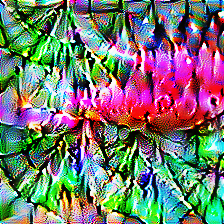

Starting iteration 491


100%|██████████| 512/512 [00:07<00:00, 69.77it/s]



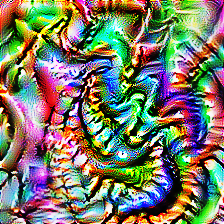

Starting iteration 492


100%|██████████| 512/512 [00:07<00:00, 68.52it/s]



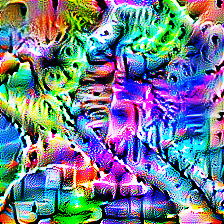

Starting iteration 493


100%|██████████| 512/512 [00:07<00:00, 68.89it/s]



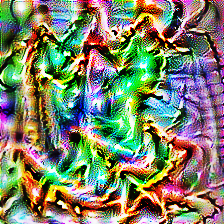

Starting iteration 494


100%|██████████| 512/512 [00:07<00:00, 67.28it/s]



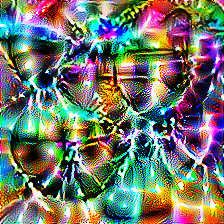

Starting iteration 495


100%|██████████| 512/512 [00:07<00:00, 66.59it/s]



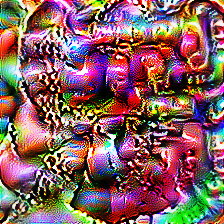

Starting iteration 496


100%|██████████| 512/512 [00:07<00:00, 67.21it/s]



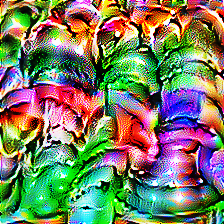

Starting iteration 497


100%|██████████| 512/512 [00:07<00:00, 66.27it/s]



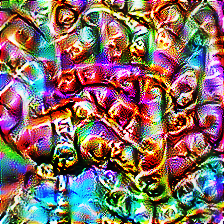

Starting iteration 498


100%|██████████| 512/512 [00:07<00:00, 65.90it/s]



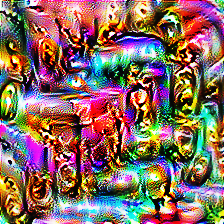

Starting iteration 499


100%|██████████| 512/512 [00:07<00:00, 67.14it/s]



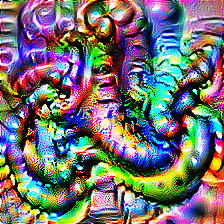

Starting iteration 500


100%|██████████| 512/512 [00:07<00:00, 66.63it/s]



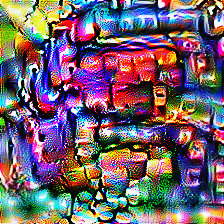

Starting iteration 501


100%|██████████| 512/512 [00:07<00:00, 66.53it/s]



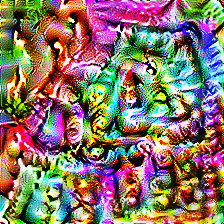

Starting iteration 502


100%|██████████| 512/512 [00:07<00:00, 64.18it/s]



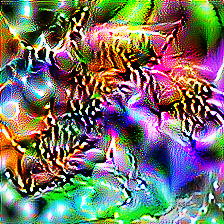

Starting iteration 503


100%|██████████| 512/512 [00:07<00:00, 65.38it/s]



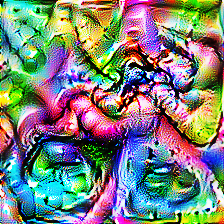

Starting iteration 504


100%|██████████| 512/512 [00:07<00:00, 65.94it/s]



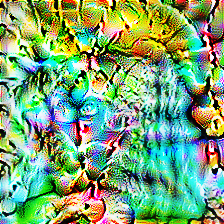

Starting iteration 505


100%|██████████| 512/512 [00:07<00:00, 65.47it/s]



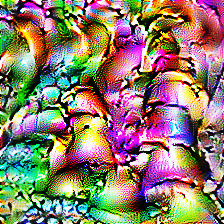

Starting iteration 506


100%|██████████| 512/512 [00:07<00:00, 65.09it/s]



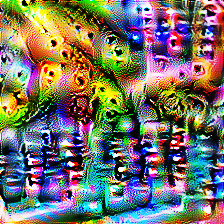

Starting iteration 507


100%|██████████| 512/512 [00:07<00:00, 64.78it/s]



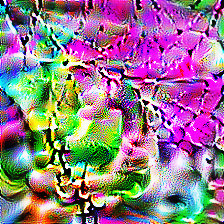

Starting iteration 508


100%|██████████| 512/512 [00:07<00:00, 65.00it/s]



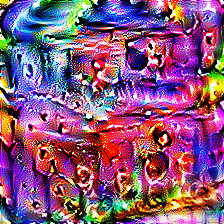

In [ ]:
def visualize_with_lucent(layer, channels):
    baseline_dir = 'Baseline/' + layer
    if not os.path.exists(baseline_dir):
      os.makedirs(baseline_dir)

    for i in range(channels):
      print(f"Starting iteration {i}")
      layer_name = layer + ':' + str(i)
      baseline_image = render.render_vis(model, layer_name, param_f_baseline, preprocess=False, show_inline=True)
      plt.imshow(baseline_image[0][0, :, :, 0:3])
      plt.axis('off')  # To turn off the axis, making the image cleaner
      plt.savefig((baseline_dir + '/' + str(i) + '.png'), bbox_inches='tight', pad_inches=0)
      plt.close()

visualize_with_lucent('layer4_1_conv2', 512)

In [ ]:
!zip -r layer4_1_conv2.zip Baseline/layer4_1_conv2/

  adding: Baseline/layer4_1_conv2/ (stored 0%)
  adding: Baseline/layer4_1_conv2/129.png (deflated 0%)
  adding: Baseline/layer4_1_conv2/452.png (deflated 0%)
  adding: Baseline/layer4_1_conv2/476.png (deflated 0%)
  adding: Baseline/layer4_1_conv2/443.png (deflated 0%)
  adding: Baseline/layer4_1_conv2/325.png (deflated 0%)
  adding: Baseline/layer4_1_conv2/343.png (deflated 0%)
  adding: Baseline/layer4_1_conv2/245.png (deflated 0%)
  adding: Baseline/layer4_1_conv2/220.png (deflated 0%)
  adding: Baseline/layer4_1_conv2/231.png (deflated 0%)
  adding: Baseline/layer4_1_conv2/107.png (deflated 0%)
  adding: Baseline/layer4_1_conv2/421.png (deflated 0%)
  adding: Baseline/layer4_1_conv2/281.png (deflated 0%)
  adding: Baseline/layer4_1_conv2/379.png (deflated 0%)
  adding: Baseline/layer4_1_conv2/20.png (deflated 0%)
  adding: Baseline/layer4_1_conv2/19.png (deflated 0%)
  adding: Baseline/layer4_1_conv2/339.png (deflated 0%)
  adding: Baseline/layer4_1_conv2/460.png (deflated 0%)
  a

In [ ]:
from google.colab import files
files.download('layer4_1_conv2.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>